In [1]:
from imports import *
import AudioTransforms
from DeReverbDataset import *
from utils import *
%matplotlib inline
from fastprogress import master_bar, progress_bar

In [2]:
plt.style.use('Solarize_Light2')  # Just changes plotting theme, comment out if annoying
matplotlib.rcParams['figure.figsize'] = [10, 8]

In [3]:
speech_sr = 16000
data_path = Path("/scratch/data")

## Create Transforms
`rev_tfms` is the transforms that will only be applied to the reverberant audio (input)  
`clean_tfms` is the transforms that will also be applied to the clean audio signal (target)

Note: if sample rate of files does not match sample rate passed, transforms will resample all audio files they need. This can take a *WHILE* if the conflicting sample rates are not integer multiples.

In [4]:
rev_files = [(data_path/'impulse-responses').ls()[0]]

In [5]:
ir_ex, irsr = lr.load(rev_files[0], sr=None)

In [6]:
rev_tfms = transforms.Compose([AudioTransforms.Reverb(rev_files, speech_sr)])#,
                               #AudioTransforms.Noise(data_path/'noise', None, -12, 2)])
clean_tfms = transforms.Compose([AudioTransforms.RandomCrop(int(2048))])

## Create a Dataset

In [7]:
dataset = DeReverbDataset(data_path, rev_tfms=rev_tfms, clean_tfms=clean_tfms)

## Create a Dataloader

In [8]:
dl = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=6, pin_memory=True)

## Check out some data

In [31]:
batch_ex = next(iter(dl))

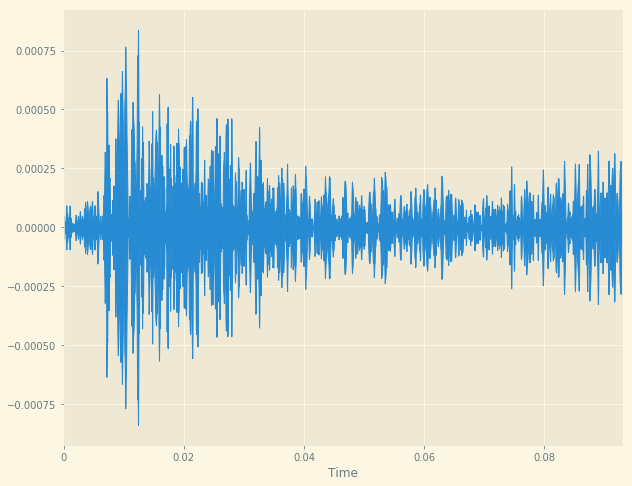

In [32]:
#plot_spec(batch_ex['reverbed'][0])
waveplot(batch_ex['reverbed'][0].squeeze().numpy())
Audio(batch_ex['reverbed'][0], rate=speech_sr)

2054

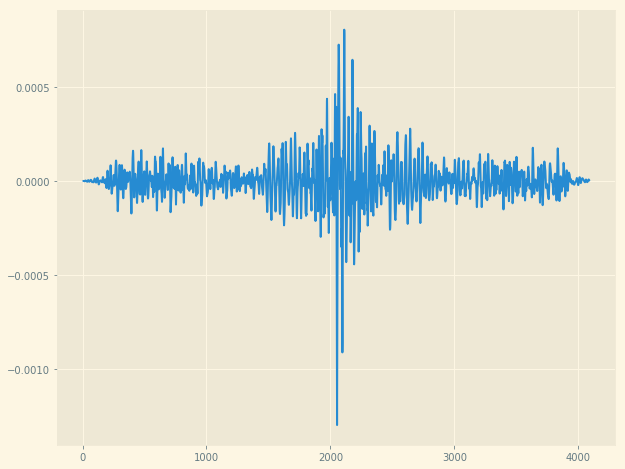

In [33]:
xcorr = np.correlate(batch_ex['reverbed'][0].squeeze().numpy(), batch_ex['clean'][0].squeeze().numpy(), 'full')

plt.plot(xcorr)

np.argmax(abs(xcorr))

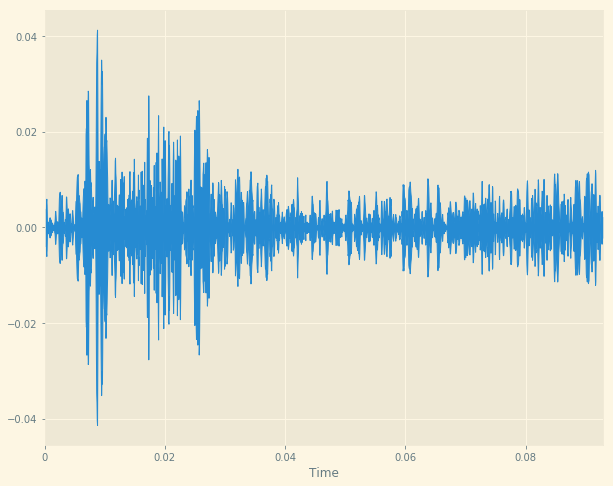

In [34]:
#plot_spec(batch_ex['clean'][0])
waveplot(batch_ex['clean'][0].squeeze().numpy())
Audio(batch_ex['clean'][0], rate=speech_sr)

## Segan network

Figure from Pandey-Wang paper

![unet](papers/images/unet-inspired.png)

In [125]:
class ConvNet(nn.Module):
    def __init__(self, kernel_size):
        super(ConvNet, self).__init__()
        sizes = [(2048, 64), (1024, 64), (512, 64), (256, 128), (128, 128), (64, 128), (32, 256), (16,256), (8, 256)]
        self.input = nn.Conv1d(1, sizes[0][1], kernel_size, 1, 3)
        self.encoder = nn.Sequential(
            *[nn.Conv1d(sizes[i-1][1], sizes[i][1], kernel_size, 2, 3) for i in range(1, len(sizes))]
        )
        self.decoder = nn.Sequential(
            *[nn.ConvTranspose1d(2*sizes[-i+1][1], sizes[-i][1], kernel_size, 2, 3,1) for i in range(2,len(sizes)+1)]
        )
        self.output = nn.ConvTranspose1d(sizes[0][1], 1, kernel_size, 1, 3)
    def forward(self, x):
        x = self.input(x)
        enc_outs = []
        for l in self.encoder:
            x = l(x)
            enc_outs.append(x)
        for i,l in enumerate(self.decoder):
            x = l(torch.cat((x, enc_outs[-i-1]), 1))
        x = self.output(x)
        return x
    
    def reconstruct(self, x):
        x = x.detach().cpu()
        size = 2048
        hop_len = 256
        window = torch.from_numpy(np.hamming(size)).float()
        output = torch.zeros(x.shape)
        for frame in range(x.shape[-1]//hop_len):
            try:
                f = x[:,hop_len*frame:hop_len*frame+size]
                f = self.forward(f.unsqueeze(0).cuda()).detach().cpu()
                windowed = window.squeeze() * f.squeeze()
                output[:,hop_len*frame:hop_len*frame+size] += windowed
            except:
                pass
        return output

In [158]:
# Try to destroy any existing network on the GPU before creating new
try:
    del cnet
except:
    pass
cnet = ConvNet(kernel_size=9)
cnet.cuda()
critereon = nn.MSELoss()
optim = torch.optim.Adam(cnet.parameters(), lr=1e-4)

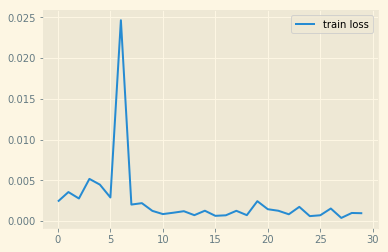

In [159]:
n_epochs = 5

mb = master_bar(range(n_epochs))
mb.names = ['train loss']
epoch_losses = []
for epoch in mb:
    for data in progress_bar(dl, parent=mb):

        epoch_loss = 0

        inputs = data['reverbed'].cuda()
        targets = data['clean'].cuda()

        outputs = cnet.forward(inputs)
        Audio(outputs.cpu().detach().squeeze().numpy(), rate=16000)
        loss = critereon(outputs, targets)
        loss.backward()
        optim.step()
        optim.zero_grad()

        epoch_loss += loss.cpu().detach().numpy()
        
    epoch_losses.append(epoch_loss)
    mb.update_graph([[range(epoch+1), epoch_losses]])
    #print(f'epoch {epoch} loss: {epoch_loss}')

In [161]:
speech_ex, sr = ta.load((data_path/'clean-speech').ls()[0])

ir_ex = ta.transforms.Resample(48000, 16000)(ta.load((data_path/'impulse-responses').ls()[2])[0])[0,:]

reverb = AudioTransforms.Reverb(rev_files, speech_sr)

reverbed = reverb(speech_ex)

In [162]:
Audio(reverbed, rate=sr)

In [169]:
Audio(speech_ex.squeeze().numpy(), rate=sr)

In [163]:
cnet.eval()

reconstructed = cnet.reconstruct(reverbed).numpy()

In [168]:
Audio(reconstructed, rate=sr)

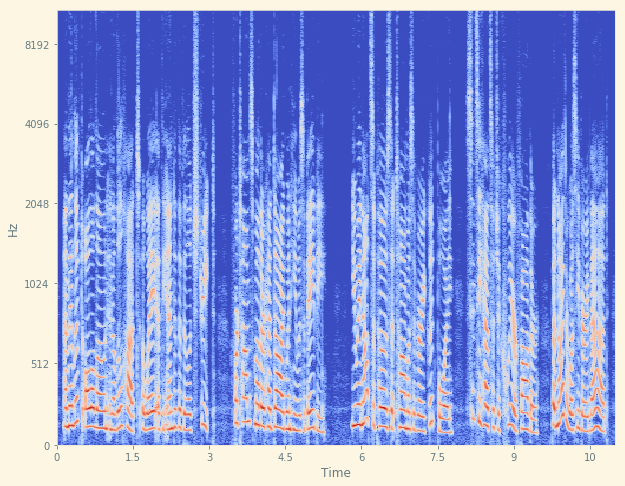

In [165]:
plot_spec(speech_ex.squeeze().numpy())

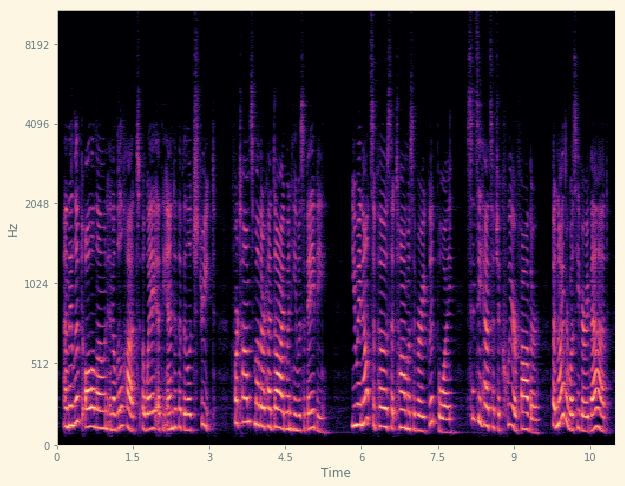

In [166]:
plot_spec(reverbed.squeeze().numpy())

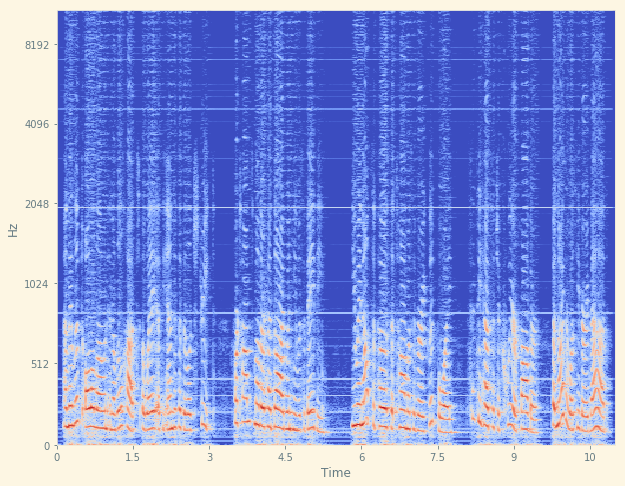

In [167]:
plot_spec(reconstructed.squeeze())

## FCNN

In [42]:
# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        self.l1 = nn.Linear(num_features, num_hidden)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(num_hidden, num_output)

    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x

In [43]:
try:
    del net
except:
    pass

speech_sr = 16000
net = Net(2048, 512, 2048)
net.cuda()

Net(
  (l1): Linear(in_features=2048, out_features=512, bias=True)
  (act): ReLU()
  (l2): Linear(in_features=512, out_features=2048, bias=True)
)

In [44]:
critereon = nn.MSELoss()
optim = torch.optim.Adam(net.parameters(), lr=1e-4)

In [ ]:
n_epochs = 100

mb = master_bar(range(n_epochs))
mb.names = ['train loss']
epoch_losses = []
for epoch in mb:
    for data in progress_bar(dl, parent=mb):

        epoch_loss = 0

        inputs = data['reverbed'].cuda()
        targets = data['clean'].cuda()

        outputs = net.forward(inputs)
        loss = critereon(outputs, targets)
        loss.backward()
        optim.step()
        optim.zero_grad()

        epoch_loss += loss.cpu().detach().numpy()
        
    epoch_losses.append(epoch_loss)
    mb.update_graph([[range(epoch+1), epoch_losses]])
    #print(f'epoch {epoch} loss: {epoch_loss}')

In [144]:
net.eval()
output = net.forward(next(iter(dl))['reverbed'].cuda())
output = output[0,:].squeeze().detach().cpu()

In [148]:
Audio(output, rate=16000)

## Ideas
1. CNN to encode frames to features
2. RNN which takes cnn frames and generates output
3. Pair with FC layer after RNN
4. Try adding a RNN to latent space to learn temporal context. Use output of rnn to reconstruct
5. Try MAE loss
6. Get working in Colab